In [1]:
import torch
import numpy as np
import torch.nn as nn

import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

Using cuda device
Epoch: 0, Loss: 0.001403
Epoch: 100, Loss: 0.187568
Epoch: 200, Loss: 0.155091
Epoch: 300, Loss: 0.120173
Epoch: 400, Loss: 0.089747
Epoch: 500, Loss: 0.061355
Epoch: 600, Loss: 0.112694
Epoch: 700, Loss: 0.082863
Epoch: 800, Loss: 0.050488
Epoch: 900, Loss: 0.027544
Epoch: 1000, Loss: 0.016590
Epoch: 1100, Loss: 0.089045
Epoch: 1200, Loss: 0.065797
Epoch: 1300, Loss: 0.045146
Epoch: 1400, Loss: 0.031228
Epoch: 1500, Loss: 0.020321
Epoch: 1600, Loss: 0.086604
Epoch: 1700, Loss: 0.056790
Epoch: 1800, Loss: 0.029840
Epoch: 1900, Loss: 0.012339
Epoch: 2000, Loss: 0.002260
Epoch: 2100, Loss: 0.047321
Epoch: 2200, Loss: 0.037018
Epoch: 2300, Loss: 0.013544
Epoch: 2400, Loss: 0.001294
Epoch: 2500, Loss: 0.001732
Epoch: 2600, Loss: 0.017172
Epoch: 2700, Loss: 0.013834
Epoch: 2800, Loss: 0.002478
Epoch: 2900, Loss: 0.000086
Epoch: 3000, Loss: 0.002507
Epoch: 3100, Loss: 0.007036
Epoch: 3200, Loss: 0.003875
Epoch: 3300, Loss: 0.000405
Epoch: 3400, Loss: 0.000007
Epoch: 3500, L

Text(0.5, 1.0, 'Grad Norm')

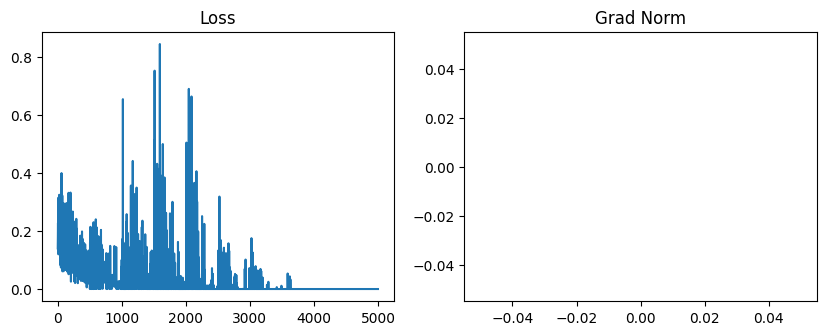

In [2]:
D = 5
L = 1000
N = 10
batchsize = 1
epochs = 5000
lr = 100
temperature = 1/25

torch.random.manual_seed(0)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

translations = []
for d in range(D):
    P = np.random.permutation(np.eye(N**2))
    translations.append(torch.tensor(P).float().to(device))

shifted_inds = [L-1] + list(range(0, L-1))
shift_mat = torch.zeros(L, L)
for i in range(L):
    shift_mat[i, shifted_inds[i]] = 1
shift_mat = shift_mat.unsqueeze(0).to(device)

I_n = torch.eye(N)
Ones_n = torch.ones(N, 1)
P1 = torch.kron(I_n, Ones_n)
P2 = torch.kron(Ones_n, I_n)
Q = (P1 @ P2.T).unsqueeze(0).to(device)
Q_t = Q.transpose(1, 2)
vocab = [chr(i) for i in range(97, 97 + N)]

def decode(mat):
    ret = []
    for i in range(len(mat[0])):
        ind = torch.argmax(mat[:, i])
        char1 = vocab[ind // N]
        char2 = vocab[ind % N]
        ret.append(char1 + char2)
    return ret

def decode_dict(D):
    for i in range(len(D)):
        input_ind = torch.argmax(D[i])
        output_ind = i
        print(vocab[input_ind // N] + vocab[input_ind % N] + " -> " + vocab[output_ind // N] + vocab[output_ind % N])

def shift(input_mat):
    shifted_input_mat = torch.matmul(input_mat, shift_mat)
    left = Q @ input_mat
    right = Q_t @ shifted_input_mat
    return left * right

def MLT(input_mat, dictionaries):

    ret = input_mat
    # print(ret)
    for D in dictionaries:
        # print(decode(ret[0]))
        ret = D @ ret
        ret = shift(ret)
        # decode_dict(D)
        # print(decode(ret[0]))
    return ret

weight_dicts = []
for i in range(D):
    # weight_dict = torch.zeros_like(translations[i])
    weight_dict = torch.randn_like(translations[i]) / N
    # weight_dict += 1/N**2
    weight_dict.requires_grad = True
    weight_dicts.append(weight_dict)

def create_mask(gt_dict, mask_inds):
    mask = gt_dict.clone()
    for i in range(len(mask_inds)):
        mask[:, mask_inds[i]] = 0
    return mask

# mask_ind = 0
random_seq = np.random.choice(N**2, (batchsize, L))
input_batch = (F.one_hot(torch.tensor(random_seq), N**2).float().transpose(-1, -2)).to(device)
with torch.no_grad():
    label_batch = MLT(input_batch, translations)

loss_record = []
grad_norm = []
weight_acc = [[] for i in range(D)]
loss_accum = 0

for i in range(epochs):
    iter_inds = i % N**2
    layer_ind = (i // N**2) % D

    masked_dict_seq = []
    for j in range(D):
        if j == layer_ind:
            tmp_mask = create_mask(translations[j], [iter_inds])
        else:
            tmp_mask = create_mask(translations[j], [])
        
        effective_weight = F.softmax((weight_dicts[j] + tmp_mask) / temperature, dim=0)
        masked_dict_seq.append(effective_weight)

    output = MLT(input_batch, masked_dict_seq)

    output_flatten = torch.cat([x for x in output], dim=1).T
    label_flatten = torch.cat([x for x in label_batch], dim=1).T
    
    for j in range(D):
        weight_max = torch.argmax(weight_dicts[j], dim=0)
        gt_max = torch.argmax(translations[j], dim=0)
        weight_acc[j].append(torch.sum(weight_max == gt_max).item() / N**2)

    loss = torch.mean((output - label_batch) ** 2)
    loss = F.cross_entropy(torch.log(output_flatten + 1e-10), torch.argmax(label_flatten, dim=1))
    loss.backward()

    loss_accum += loss.item()
    loss_record.append(loss.item())
    
    if i % 100 == 0:
        print("Epoch: %d, Loss: %f" % (i, loss_accum / 100))
        loss_accum = 0

    # for j in range(D):
    #     with torch.no_grad():
    #         weight_dicts[j] -= lr * weight_dicts[j].grad
    #         weight_dicts[j].grad.zero_()
    #         weight_dicts[j].clip_(0, 1)

    with torch.no_grad():
        weight_dicts[layer_ind] -= lr * weight_dicts[layer_ind].grad
        weight_dicts[layer_ind].clip_(0, 1)
        for j in range(D):
            weight_dicts[j].grad.zero_()

plt.figure(figsize=(10, 3.5))
plt.subplot(1, 2, 1)
plt.plot(loss_record)
plt.title("Loss")
plt.subplot(1, 2, 2)
plt.plot(grad_norm)
plt.title("Grad Norm")

In [3]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

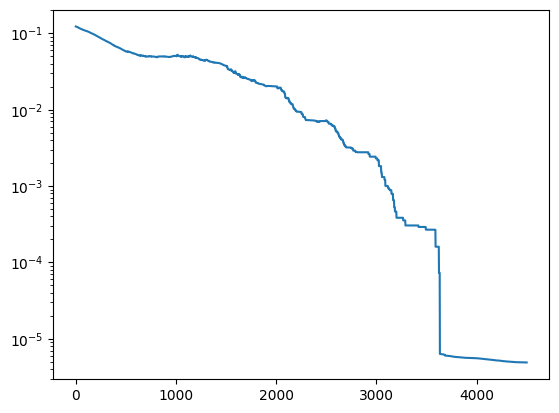

In [4]:
plt.plot(moving_average(loss_record, 500))
plt.yscale('log')

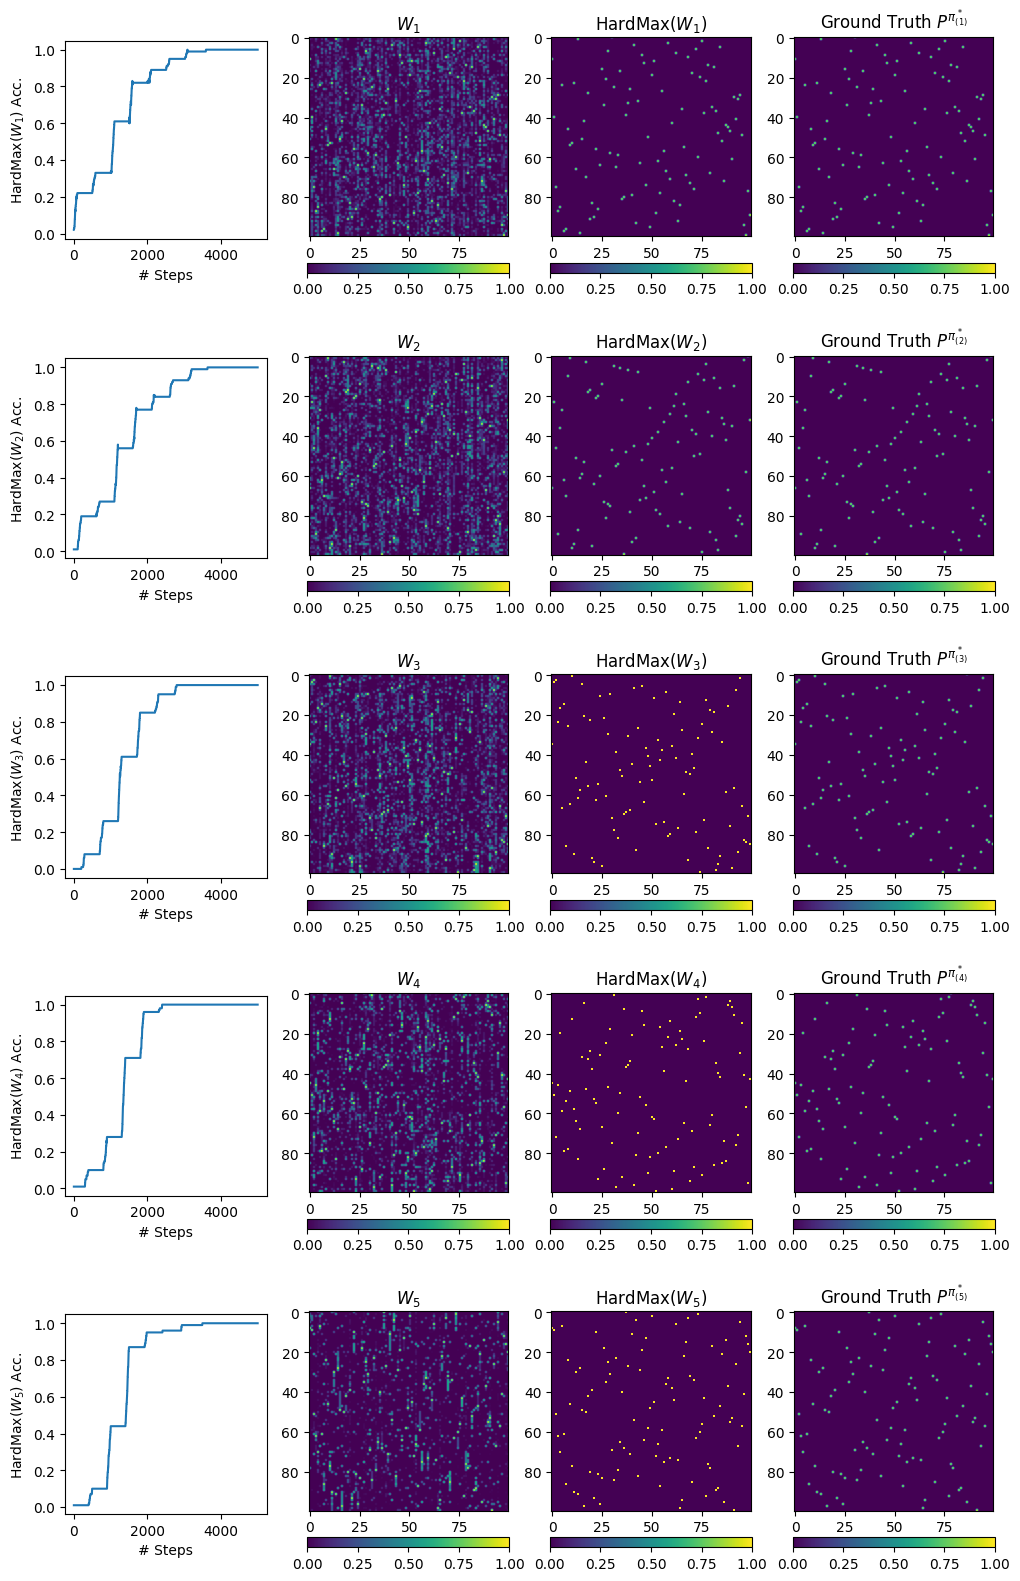

In [7]:
stepsize = 1
plt.figure(figsize=(12, 4*D // stepsize), dpi=100)
gs = gridspec.GridSpec(D // stepsize, 4)
for pi, i in enumerate(range(0, D, stepsize)):

    ax = plt.subplot(gs[pi, 0])
    ax.set_aspect(5000 ,adjustable='box')
    ax.plot(weight_acc[i], label="Layer %d" % i)
    ax.set_ylabel(r"HardMax($W_{{XXX}}$) Acc.".replace("XXX", str(i + 1)))
    ax.set_xlabel("# Steps")
    pos = ax.get_position()  # Get current position
    ax.set_position([pos.x0, pos.y0 + 0.015, pos.width, pos.height])  # Adjust y0

    ax = plt.subplot(gs[pi, 1])
    ax.set_title(r"$W_{{XXX}}$".replace("XXX", str(i + 1)))
    im = ax.imshow(weight_dicts[i].detach().cpu().numpy())
    plt.colorbar(im, ax=ax, shrink=1, orientation='horizontal', pad=0.1)

    ax = plt.subplot(gs[pi, 2])
    ax.set_title(r"HardMax($W_{{XXX}}$)".replace("XXX", str(i + 1)))
    im = ax.imshow(torch.softmax(100*weight_dicts[i], dim=1).detach().cpu().numpy())
    plt.colorbar(im, ax=ax, shrink=1, orientation='horizontal', pad=0.1)

    ax = plt.subplot(gs[pi, 3])
    ax.set_title(r"Ground Truth $P^{\pi^*_{(XXX)}}$".replace("XXX", str(i + 1)))
    im = ax.imshow(translations[i].detach().cpu().numpy())
    plt.colorbar(im, ax=ax, shrink=1, orientation='horizontal', pad=0.1)

# plt.tight_layout()
plt.savefig("./figs/N10D5L1000_layerwise.pdf", bbox_inches='tight', pad_inches=0)
# plt.figure(figsize=(10, 3.5))
# plt.subplot(1, 3, 1)
# plt.title("Ground Truth")
# plt.imshow(translations[0].detach().cpu().numpy())
# plt.colorbar()
# plt.subplot(1, 3, 2)
# plt.title("Weight")
# plt.imshow(weight_dict1.detach().cpu().numpy())
# plt.colorbar()
# plt.subplot(1, 3, 3)
# plt.title("Effective Matrix")
# plt.imshow(F.softmax(10 * (weight_dict1), dim=0).detach().cpu().numpy())
# plt.colorbar()
plt.show()


In [8]:
weight_acc_layerwise = np.array(weight_acc)

Using cuda device
Epoch: 0, Loss: 0.001240
Epoch: 100, Loss: 0.193195
Epoch: 200, Loss: 0.156860
Epoch: 300, Loss: 0.121408
Epoch: 400, Loss: 0.090713
Epoch: 500, Loss: 0.064440
Epoch: 600, Loss: 0.117711
Epoch: 700, Loss: 0.082305
Epoch: 800, Loss: 0.050225
Epoch: 900, Loss: 0.025036
Epoch: 1000, Loss: 0.013943
Epoch: 1100, Loss: 0.105815
Epoch: 1200, Loss: 0.065310
Epoch: 1300, Loss: 0.036725
Epoch: 1400, Loss: 0.028950
Epoch: 1500, Loss: 0.023858
Epoch: 1600, Loss: 0.068690
Epoch: 1700, Loss: 0.051832
Epoch: 1800, Loss: 0.031907
Epoch: 1900, Loss: 0.012224
Epoch: 2000, Loss: 0.004255
Epoch: 2100, Loss: 0.040373
Epoch: 2200, Loss: 0.012885
Epoch: 2300, Loss: 0.012473
Epoch: 2400, Loss: 0.003287
Epoch: 2500, Loss: 0.001382
Epoch: 2600, Loss: 0.008481
Epoch: 2700, Loss: 0.004040
Epoch: 2800, Loss: 0.002647
Epoch: 2900, Loss: 0.000622
Epoch: 3000, Loss: 0.000172
Epoch: 3100, Loss: 0.002773
Epoch: 3200, Loss: 0.001163
Epoch: 3300, Loss: 0.000371
Epoch: 3400, Loss: 0.000638
Epoch: 3500, L

Text(0.5, 1.0, 'Grad Norm')

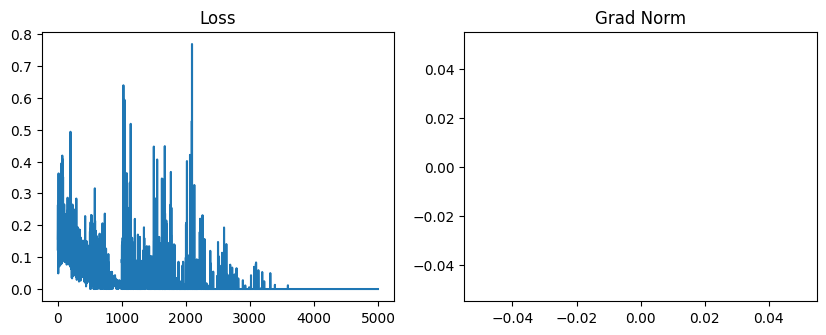

In [11]:
D = 5
L = 1000
N = 10
batchsize = 1
epochs = 5000
lr = 100
temperature = 1/25

torch.random.manual_seed(0)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

translations = []
for d in range(D):
    P = np.random.permutation(np.eye(N**2))
    translations.append(torch.tensor(P).float().to(device))

shifted_inds = [L-1] + list(range(0, L-1))
shift_mat = torch.zeros(L, L)
for i in range(L):
    shift_mat[i, shifted_inds[i]] = 1
shift_mat = shift_mat.unsqueeze(0).to(device)

I_n = torch.eye(N)
Ones_n = torch.ones(N, 1)
P1 = torch.kron(I_n, Ones_n)
P2 = torch.kron(Ones_n, I_n)
Q = (P1 @ P2.T).unsqueeze(0).to(device)
Q_t = Q.transpose(1, 2)
vocab = [chr(i) for i in range(97, 97 + N)]

def decode(mat):
    ret = []
    for i in range(len(mat[0])):
        ind = torch.argmax(mat[:, i])
        char1 = vocab[ind // N]
        char2 = vocab[ind % N]
        ret.append(char1 + char2)
    return ret

def decode_dict(D):
    for i in range(len(D)):
        input_ind = torch.argmax(D[i])
        output_ind = i
        print(vocab[input_ind // N] + vocab[input_ind % N] + " -> " + vocab[output_ind // N] + vocab[output_ind % N])

def shift(input_mat):
    shifted_input_mat = torch.matmul(input_mat, shift_mat)
    left = Q @ input_mat
    right = Q_t @ shifted_input_mat
    return left * right

def MLT(input_mat, dictionaries):

    ret = input_mat
    # print(ret)
    for D in dictionaries:
        # print(decode(ret[0]))
        ret = D @ ret
        ret = shift(ret)
        # decode_dict(D)
        # print(decode(ret[0]))
    return ret

weight_dicts = []
for i in range(D):
    # weight_dict = torch.zeros_like(translations[i])
    weight_dict = torch.randn_like(translations[i]) / N
    # weight_dict += 1/N**2
    weight_dict.requires_grad = True
    weight_dicts.append(weight_dict)

def create_mask(gt_dict, mask_inds):
    mask = gt_dict.clone()
    for i in range(len(mask_inds)):
        mask[:, mask_inds[i]] = 0
    return mask

# mask_ind = 0
random_seq = np.random.choice(N**2, (batchsize, L))
input_batch = (F.one_hot(torch.tensor(random_seq), N**2).float().transpose(-1, -2)).to(device)
with torch.no_grad():
    label_batch = MLT(input_batch, translations)

loss_record = []
grad_norm = []
weight_acc = [[] for i in range(D)]
loss_accum = 0

for i in range(epochs):
    iter_inds = i % N**2
    layer_ind = (i // N**2) % D

    masked_dict_seq = []
    for j in range(D):
        if j == layer_ind:
            tmp_mask = create_mask(translations[j], [iter_inds])
        else:
            tmp_mask = create_mask(translations[j], [])
        
        effective_weight = F.softmax((weight_dicts[j] + tmp_mask) / temperature, dim=0)
        masked_dict_seq.append(effective_weight)

    output = MLT(input_batch, masked_dict_seq)

    output_flatten = torch.cat([x for x in output], dim=1).T
    label_flatten = torch.cat([x for x in label_batch], dim=1).T
    
    for j in range(D):
        weight_max = torch.argmax(weight_dicts[j], dim=0)
        gt_max = torch.argmax(translations[j], dim=0)
        weight_acc[j].append(torch.sum(weight_max == gt_max).item() / N**2)

    loss = torch.mean((output - label_batch) ** 2)
    loss = F.cross_entropy(torch.log(output_flatten + 1e-10), torch.argmax(label_flatten, dim=1))
    loss.backward()

    loss_accum += loss.item()
    loss_record.append(loss.item())
    
    if i % 100 == 0:
        print("Epoch: %d, Loss: %f" % (i, loss_accum / 100))
        loss_accum = 0

    for j in range(D):
        with torch.no_grad():
            weight_dicts[j] -= lr * weight_dicts[j].grad
            weight_dicts[j].grad.zero_()
            weight_dicts[j].clip_(0, 1)

    # with torch.no_grad():
    #     weight_dicts[layer_ind] -= lr * weight_dicts[layer_ind].grad
    #     weight_dicts[layer_ind].grad.zero_()
    #     weight_dicts[layer_ind].clip_(0, 1)

plt.figure(figsize=(10, 3.5))
plt.subplot(1, 2, 1)
plt.plot(loss_record)
plt.title("Loss")
plt.subplot(1, 2, 2)
plt.plot(grad_norm)
plt.title("Grad Norm")

In [12]:
weight_acc_nonlayerwise = np.array(weight_acc)

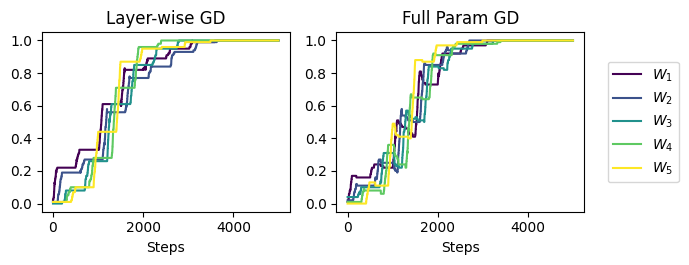

In [13]:

colors = plt.cm.viridis(np.linspace(0, 1, D))

gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.1])
figure = plt.figure(figsize=(7, 2.75))
ax1 = plt.subplot(gs[0, 0])

for i in range(D):
    ax1.plot(weight_acc_layerwise[i], label=r"$W_{{%d}}$" % (i+1), color=colors[i])
# ax.legend(bbox_to_anchor=(1.05, 1.05), loc='upper left')
# ax.set_title(r"Accuracy of HardMax($W_i$) vs $W_i^*$")
ax1.set_title(r"Layer-wise GD")
ax1.set_xlabel("Steps")

ax2 = plt.subplot(gs[0, 1])
for i in range(D):
    ax2.plot(weight_acc_nonlayerwise[i], label=r"$W_{{%d}}$" % (i+1), color=colors[i])
# ax.legend(bbox_to_anchor=(1.05, 1.05), loc='upper left')
ax2.set_title(r"Full Param GD")
ax2.set_xlabel("Steps")

ax3 = plt.subplot(gs[0,2])
ax3.axis('off')  # Turn off the axis

# Add the legend
ax3.legend(*ax2.get_legend_handles_labels(), loc='center')
plt.tight_layout()
plt.savefig("./figs/N10D5_layerwise_vs_fullparam.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

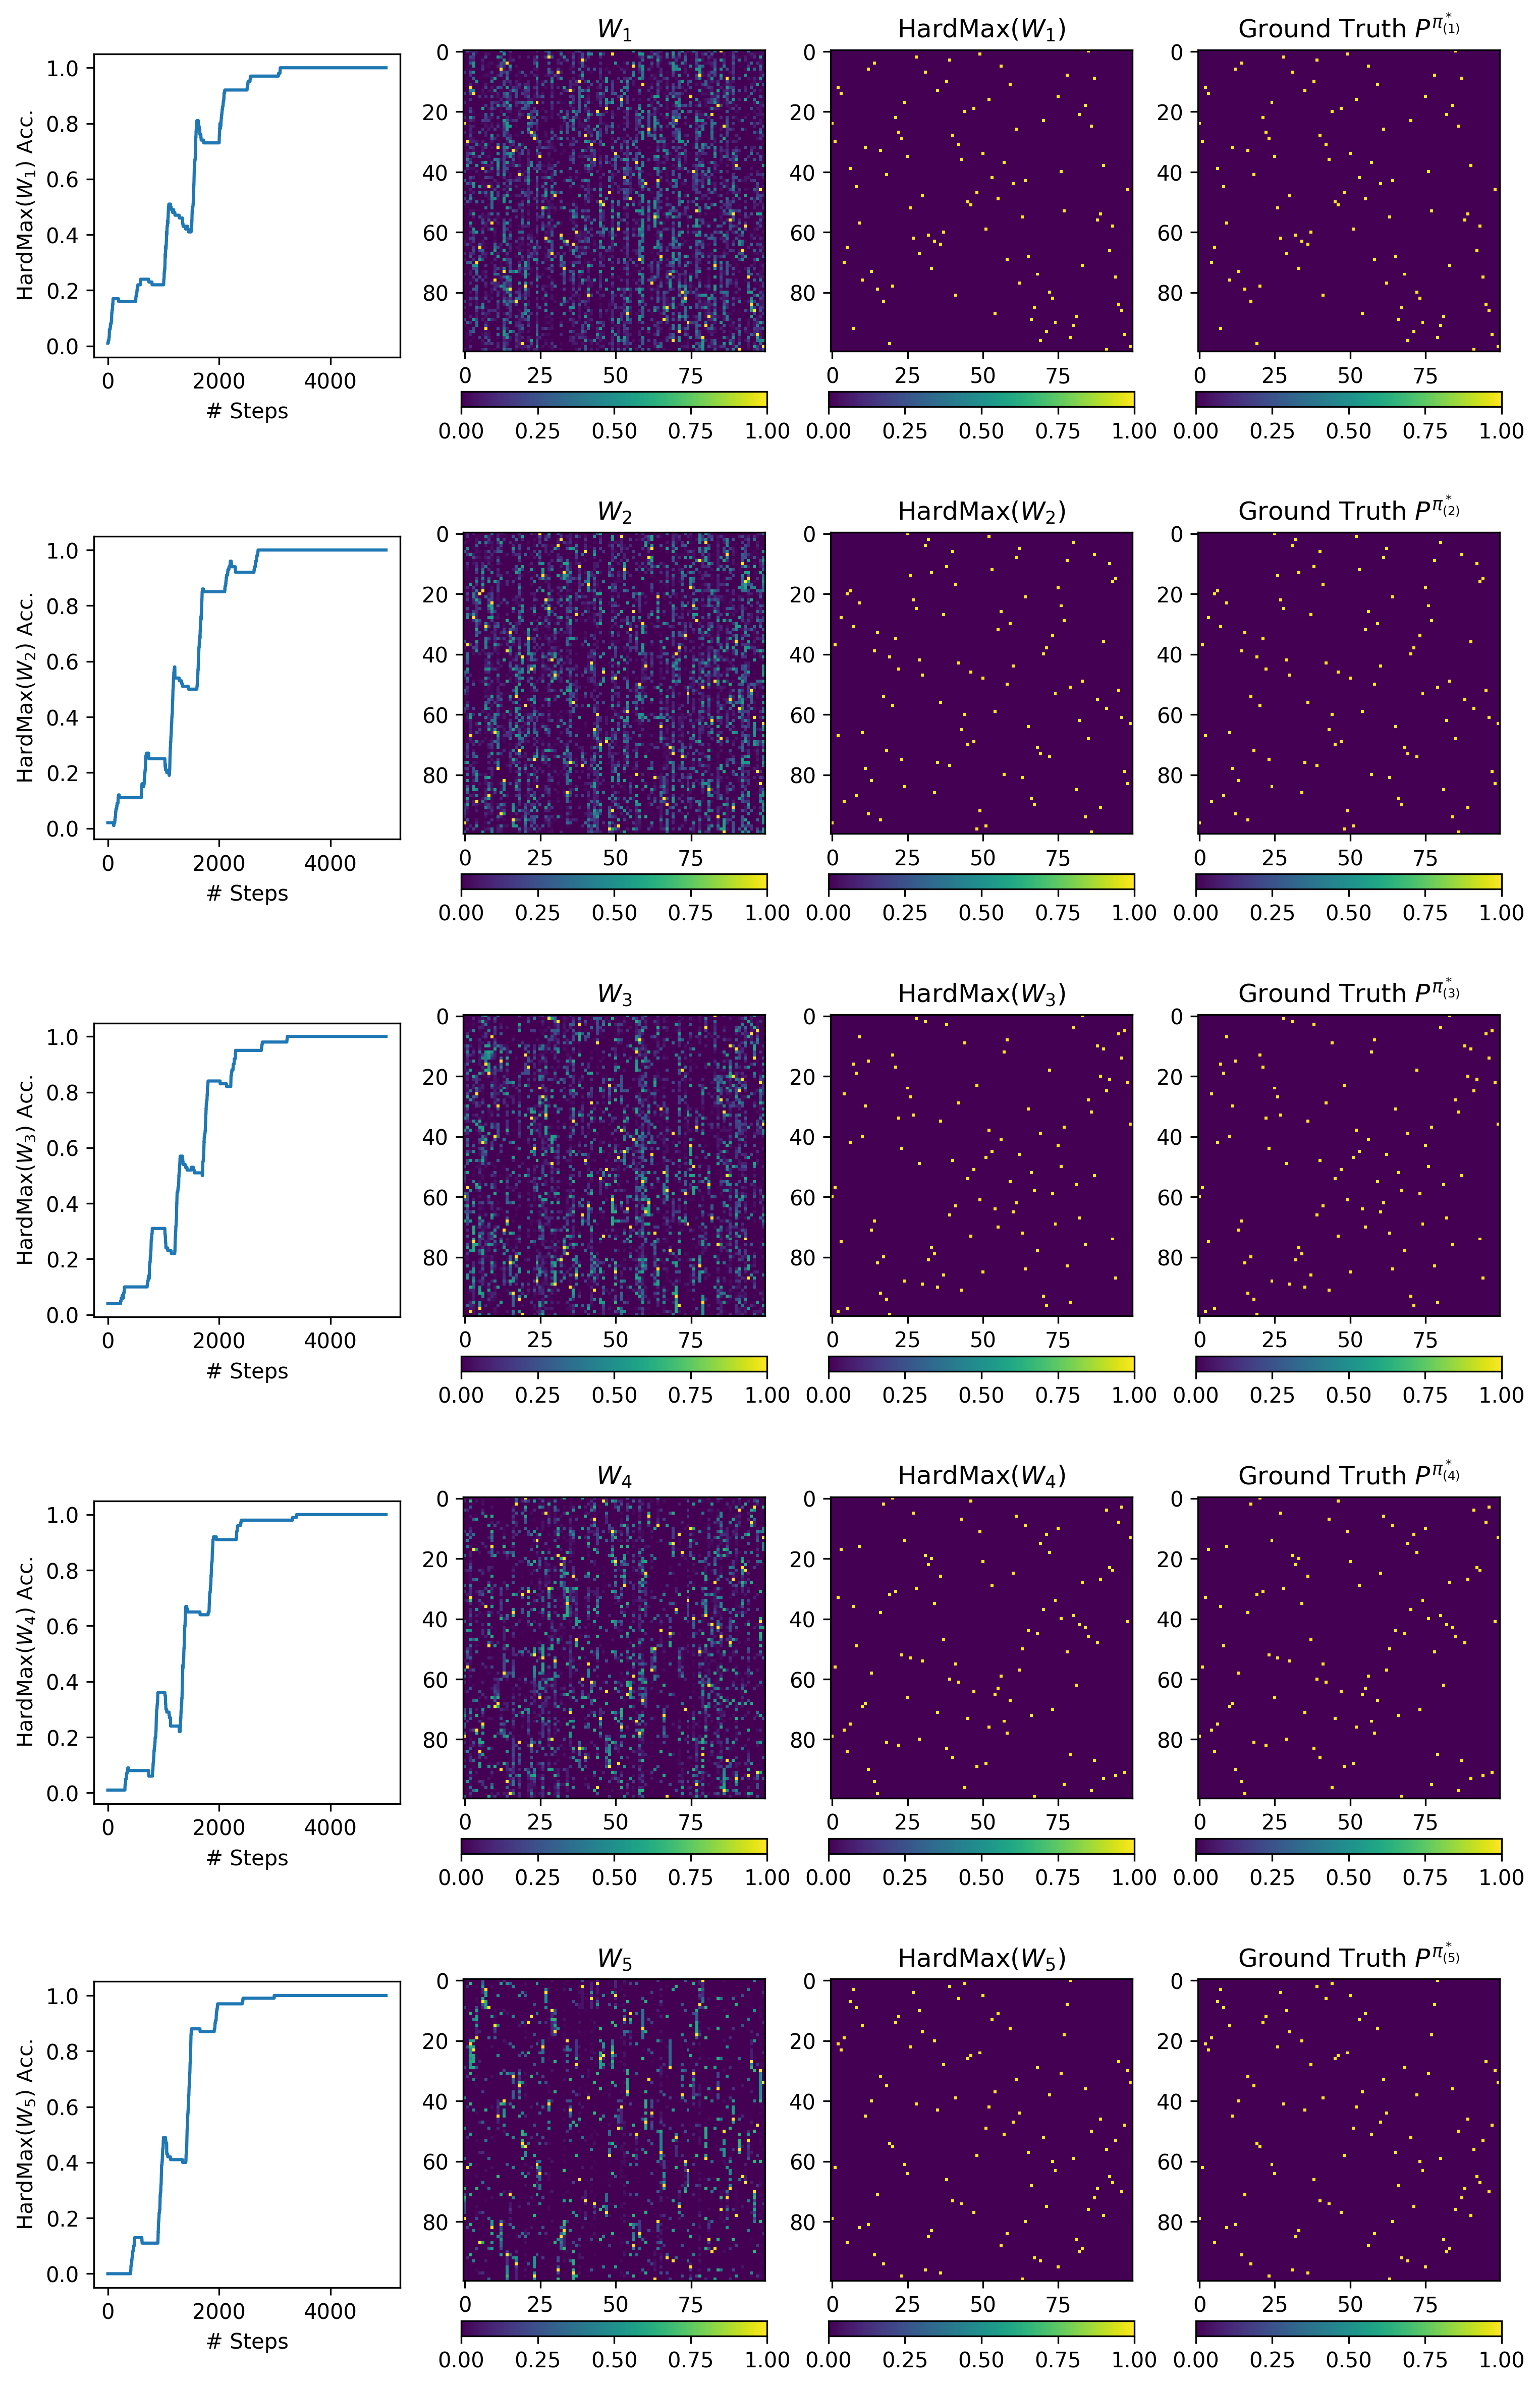

In [15]:
stepsize = 1
plt.figure(figsize=(12, 4*D // stepsize), dpi=300)
gs = gridspec.GridSpec(D // stepsize, 4)
for pi, i in enumerate(range(0, D, stepsize)):

    ax = plt.subplot(gs[pi, 0])
    ax.set_aspect(5000 ,adjustable='box')
    ax.plot(weight_acc[i], label="Layer %d" % i)
    ax.set_ylabel(r"HardMax($W_{{XXX}}$) Acc.".replace("XXX", str(i + 1)))
    ax.set_xlabel("# Steps")
    pos = ax.get_position()  # Get current position
    ax.set_position([pos.x0, pos.y0 + 0.015, pos.width, pos.height])  # Adjust y0

    ax = plt.subplot(gs[pi, 1])
    ax.set_title(r"$W_{{XXX}}$".replace("XXX", str(i + 1)))
    im = ax.imshow(weight_dicts[i].detach().cpu().numpy())
    plt.colorbar(im, ax=ax, shrink=1, orientation='horizontal', pad=0.1)

    ax = plt.subplot(gs[pi, 2])
    ax.set_title(r"HardMax($W_{{XXX}}$)".replace("XXX", str(i + 1)))
    im = ax.imshow(torch.softmax(100*weight_dicts[i], dim=1).detach().cpu().numpy())
    plt.colorbar(im, ax=ax, shrink=1, orientation='horizontal', pad=0.1)

    ax = plt.subplot(gs[pi, 3])
    ax.set_title(r"Ground Truth $P^{\pi^*_{(XXX)}}$".replace("XXX", str(i + 1)))
    im = ax.imshow(translations[i].detach().cpu().numpy())
    plt.colorbar(im, ax=ax, shrink=1, orientation='horizontal', pad=0.1)


# plt.tight_layout()
plt.savefig("./figs/N10D5L1000_fullparam.pdf", bbox_inches='tight', pad_inches=0)



# plt.figure(figsize=(10, 3.5))
# plt.subplot(1, 3, 1)
# plt.title("Ground Truth")
# plt.imshow(translations[0].detach().cpu().numpy())
# plt.colorbar()
# plt.subplot(1, 3, 2)
# plt.title("Weight")
# plt.imshow(weight_dict1.detach().cpu().numpy())
# plt.colorbar()
# plt.subplot(1, 3, 3)
# plt.title("Effective Matrix")
# plt.imshow(F.softmax(10 * (weight_dict1), dim=0).detach().cpu().numpy())
# plt.colorbar()
plt.show()


In [42]:
print(torch.argmax(weight_dict1, dim=-1))
print(torch.argmax(translations[0], dim=-1))

tensor([19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
        19, 19, 19, 19, 19, 19, 19], device='cuda:0')
tensor([24, 19,  5, 10, 23,  8,  9, 22,  7, 11, 21, 17,  1,  2, 18, 15,  4, 16,
        12,  6, 20, 13, 14,  0,  3], device='cuda:0')


AttributeError: 'NoneType' object has no attribute 'cpu'

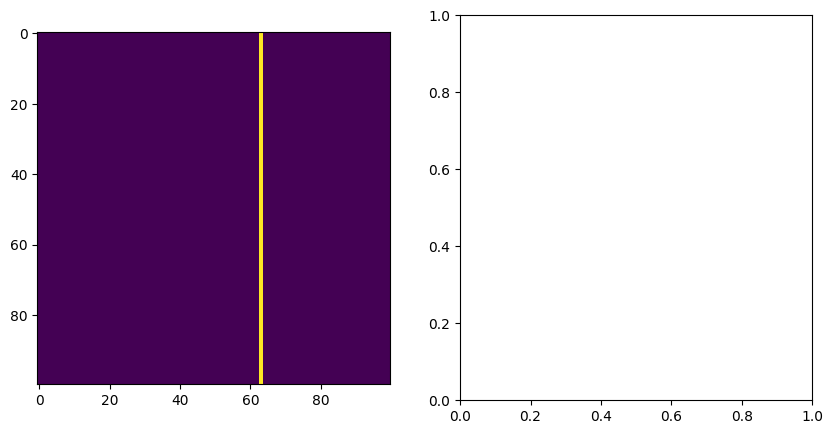

In [ ]:
def MLT(input_mat, dictionaries):

    ret = input_mat.clone()
    # print(ret)
    for D in dictionaries:
        ret = shift_mat(ret)
        # print(decode(ret))
        ret = D @ ret
        # decode_dict(D)
        # print(decode(ret))
    return ret

seqs = []
labels = []
for i in range(20):
    random_seq = np.random.choice(N**2, L)
    input_mat = (F.one_hot(torch.tensor(random_seq), N**2).float().T).to(device)
    seqs.append(input_mat)

masked_dict1 = torch.clone(translations[0])
# masked_ind = np.random.choice(N**2, 1)

# gt = translations[0][:, masked_ind]
# gt_ind = torch.argmax(gt)

masked_dict1 *= 0
masked_dict1[:, masked_ind] += 1 / N**2
# random_ind = np.random.choice(N**2, 1)
masked_dict1.requires_grad = True

masked_dict_seq = [masked_dict1]
for i in range(1, D):
    masked_dict_seq.append(translations[i])

for inputs, labels in zip(seqs, labels):
    output = MLT(inputs, masked_dict_seq)
    loss = F.mse_loss(output, labels)
    loss.backward()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(masked_dict1.detach().cpu().numpy())
plt.subplot(1, 2, 2)
plt.imshow(masked_dict1.grad.cpu().numpy())
plt.show()

grad_missing = masked_dict1.grad[:, masked_ind].detach().cpu().numpy()
plt.plot(grad_missing)
plt.title("GT ind: " + str(gt_ind.item()))
print(masked_dict1.grad)

In [65]:

print(decode(input_mat))
shifted_mat = shift_mat(input_mat)
decode(shifted_mat)

['ca', 'ca', 'cc', 'ac', 'ba', 'aa', 'ca', 'ba', 'bc', 'bb']


['ac', 'ac', 'ca', 'cb', 'aa', 'ac', 'ab', 'ab', 'cb', 'bc']

In [37]:
import numpy as np
import matplotlib.pyplot as plt

def create_character_permutation_matrix(n=30, character='A'):
    """
    Generate a permutation matrix that visually represents a character.
    
    Parameters:
    - n: Matrix size
    - character: Character to represent
    
    Returns:
    - Permutation matrix
    """
    # Create a blank matrix
    matrix = np.zeros((n, n), dtype=int)
    
    # Define character patterns
    if character == 'A':
        # Create an 'A' shape
        for i in range(n):
            for j in range(n):
                # Create diagonal lines of A
                if (abs(j - n/2) < n/5 and 
                    i > n/3 and 
                    i < 2*n/3 and 
                    abs(i - n/2) + abs(j - n/2) < n/4):
                    matrix[i, j] = 1
    
    elif character == 'H':
        # Create an 'H' shape
        for i in range(n):
            for j in range(n):
                # Vertical lines
                if ((j > n/3 and j < n/3 + n/10) or 
                    (j > 2*n/3 - n/10 and j < 2*n/3)) and \
                   (i > n/4 and i < 3*n/4):
                    matrix[i, j] = 1
                
                # Horizontal line
                if (i > n/2 - n/20 and i < n/2 + n/20) and \
                   (j > n/4 and j < 3*n/4):
                    matrix[i, j] = 1
    
    # Verify it's a valid permutation matrix
    matrix = make_valid_permutation(matrix)
    
    return matrix

def make_valid_permutation(matrix):
    """
    Ensure the matrix is a valid permutation matrix.
    """
    n = matrix.shape[0]
    valid_matrix = np.zeros_like(matrix)
    
    # Find rows and columns with 1s
    row_indices = np.where(matrix.sum(axis=1) > 0)[0]
    col_indices = np.where(matrix.sum(axis=0) > 0)[0]
    
    # Permute these indices to create a valid permutation
    np.random.seed(42)
    permuted_rows = np.random.permutation(row_indices)
    
    for orig, perm in zip(row_indices, permuted_rows):
        col = col_indices[np.where(matrix[orig] > 0)[0][0]]
        valid_matrix[perm, col] = 1
    
    return valid_matrix

def visualize_character_matrix(character='A'):
    """
    Visualize the character-shaped permutation matrix.
    """
    plt.figure(figsize=(10, 10))
    matrix = create_character_permutation_matrix(n=50, character=character)
    
    plt.imshow(matrix)
    plt.title(f'Permutation Matrix Forming Character: {character}')
    plt.show()

# Demonstrate character matrices
visualize_character_matrix('A')
visualize_character_matrix('H')

IndexError: index 21 is out of bounds for axis 0 with size 19

<Figure size 1000x1000 with 0 Axes>